In [5]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

In [6]:
def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0, prices=True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val

In [7]:
def show_gbm(n_scenario, returns, volatility, capital, n_years):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    prices = gbm(
        n_scenarios=n_scenario,
        mu=returns, 
        sigma=volatility, 
        s_0=capital, 
        n_years=n_years
    )
    ax = prices.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,6))
    ax.axhline(y=capital, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0,capital, marker='o',color='darkred', alpha=0.2)

In [8]:
# Choses à rajouter : 
# répartition sur les déciles + La moyenne
# Patrimoine Moyen + Median
# Probabilité de perte
# Probabilité de doubler
# Probabilité de ruine
# Volatilité moyenne + mediane
# Rendement moyen + median 
# catégorisation des actifs (actions, obligations, immobilier, etc.)
# Prise en compte de l'inflation
# Prise en compte de l'imposition


In [9]:
gbm_controls = widgets.interactive(
    show_gbm, 
    n_scenario=widgets.IntSlider(min=1, max=1000, step=1, value=1), 
    returns=(0., +.2,.01),
    volatility=(0, .3, .01),
    capital=(100,10000,100),
    n_years=(1,25,1)
)

display(gbm_controls)

interactive(children=(IntSlider(value=1, description='n_scenario', max=1000, min=1), FloatSlider(value=0.1, de…

In [14]:
import numpy as np
import pandas as pd

def gbm_multi(n_steps=252, n_scenarios=1000, mu=None, sigma=None, corr_matrix=None, s_0=None, prices=True):
    """
    Evolution of correlated Geometric Brownian Motion trajectories for multiple assets via Monte Carlo.
    
    :param n_steps: granularity of the simulation
    :param n_scenarios: The number of scenarios/trajectories
    :param mu: Array of annualized drifts (length n_assets)
    :param sigma: Array of annualized volatilities (length n_assets)
    :param corr_matrix: Correlation matrix (n_assets x n_assets)
    :param s_0: Array of initial values for each asset (length n_assets)
    :param prices: if True, returns price paths; otherwise returns returns
    :return: a 3D numpy array of shape (n_steps, n_scenarios, n_assets)
    """
    mu = np.array(mu)
    sigma = np.array(sigma)
    s_0 = np.array(s_0)
    n_assets = len(mu)

    dt = 1 / 252

    cov_matrix = np.outer(sigma, sigma) * corr_matrix
    chol_matrix = np.linalg.cholesky(cov_matrix)

    # Simulate correlated random shocks
    Z = np.random.normal(size=(n_steps, n_scenarios, n_assets))
    correlated_Z = Z @ chol_matrix.T

    # Calculate drift and diffusion
    drift = (1 + mu) ** dt
    diffusion = np.sqrt(dt)

    # Initialize return paths
    rets_plus_1 = np.empty((n_steps, n_scenarios, n_assets))
    rets_plus_1[0] = 1  # initial value for returns

    for i in range(1, n_steps):
        rets_plus_1[i] = drift * np.exp(correlated_Z[i] * diffusion)

    if prices:
        ret_val = s_0 * np.cumprod(rets_plus_1, axis=0)
    else:
        ret_val = rets_plus_1 - 1

    return ret_val  # shape: (n_steps, n_scenarios, n_assets)


In [ ]:
import numpy as np
import pandas as pd

def gbm_multi(n_steps=252, n_scenarios=1000, mu=None, sigma=None, corr_matrix=None, s_0=None,
              allocation=None, prices=True):
    """
    Evolution of correlated GBM portfolio via Monte Carlo, returning aggregate portfolio trajectories.
    
    :param n_steps: number of time steps
    :param n_scenarios: number of Monte Carlo scenarios
    :param mu: array of annualized expected returns (length n_assets)
    :param sigma: array of annualized volatilities (length n_assets)
    :param corr_matrix: correlation matrix (n_assets x n_assets)
    :param s_0: array of initial prices (length n_assets)
    :param allocation: array of portfolio weights (length n_assets)
    :param prices: if True, return price paths; otherwise return returns
    :return: 2D numpy array of shape (n_steps, n_scenarios) — portfolio value or return
    """
    mu = np.array(mu)
    sigma = np.array(sigma)
    s_0 = np.array(s_0)
    allocation = np.array(allocation)
    n_assets = len(mu)
    
    assert mu.shape[0] == sigma.shape[0] == s_0.shape[0] == allocation.shape[0], "Shape mismatch among inputs"
    assert np.isclose(np.sum(allocation), 1), "Allocation weights must sum to 1"

    dt = 1 / 252

    cov_matrix = np.outer(sigma, sigma) * corr_matrix
    chol_matrix = np.linalg.cholesky(cov_matrix)

    # Simulate correlated shocks
    Z = np.random.normal(size=(n_steps, n_scenarios, n_assets))
    correlated_Z = Z @ chol_matrix.T

    # Drift and diffusion
    drift = (1 + mu) ** dt
    diffusion = np.sqrt(dt)

    rets_plus_1 = np.empty((n_steps, n_scenarios, n_assets))
    rets_plus_1[0] = 1

    for i in range(1, n_steps):
        rets_plus_1[i] = drift * np.exp(correlated_Z[i] * diffusion)

    if prices:
        asset_prices = s_0 * np.cumprod(rets_plus_1, axis=0)
        portfolio_prices = asset_prices @ allocation
        return portfolio_prices
    else:
        asset_returns = rets_plus_1 - 1
        portfolio_returns = (asset_returns @ allocation)
        return portfolio_returns


C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


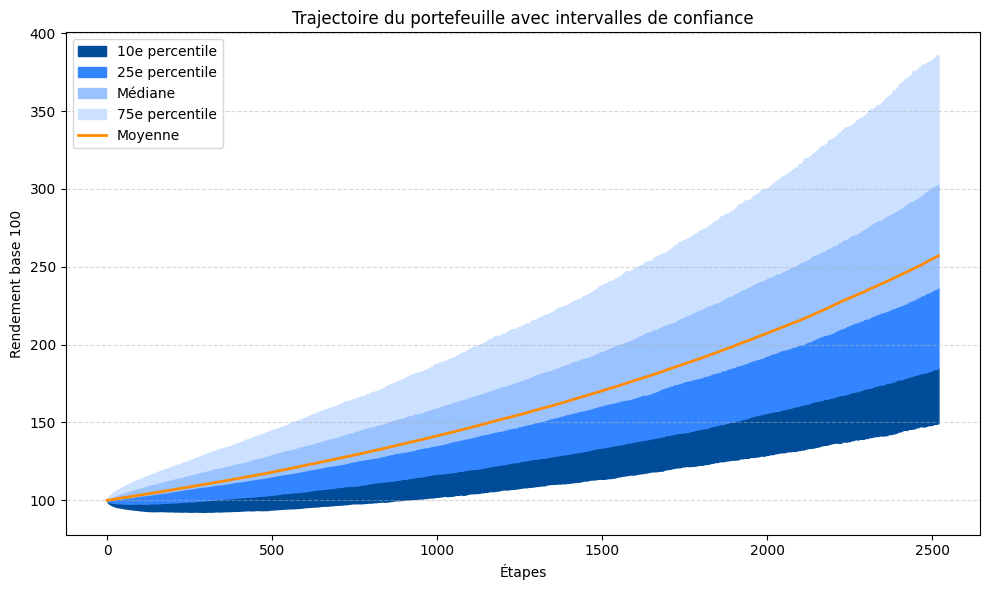

In [67]:
# Données réelles
import yfinance as yf
from FinanceToolkit import AssetManagement as am
import matplotlib.pyplot as plt

tickers = ['^FCHI', 'GOLD.PA', '0P00008W4R.F']
history = pd.DataFrame()
for ticker in tickers:
    data = yf.Ticker(ticker).history('10y')['Close']
    data.name = ticker
    history = pd.concat([history, data], axis=1)
history.index = pd.to_datetime(history.index)
history = history.resample('B').last().ffill()
history.index = history.index.tz_localize(None)
history = history.dropna()

mu = am.theta(history)
sigma = am.sigma(history)
corr_matrix = history.pct_change(fill_method=None).corr().values
s_0 = [100, 100, 100]

allocation = [0.6, 0.2, 0.2]
n_steps = 252*10
n_scenarios = 10000

data = gbm_multi(
    n_steps=n_steps,
    n_scenarios=n_scenarios,
    mu=mu,
    sigma=sigma,
    corr_matrix=corr_matrix,
    s_0=s_0,
    allocation=allocation,
    prices=True
)

# Calcul des percentiles
p10 = np.percentile(data, 10, axis=1)
p25 = np.percentile(data, 25, axis=1)
p50 = np.percentile(data, 50, axis=1)
p75 = np.percentile(data, 75, axis=1)
p90 = np.percentile(data, 90, axis=1)
mean = np.mean(data, axis=1)

# Tracer les intervalles
plt.figure(figsize=(10, 6))
plt.fill_between(range(n_steps), p10, p25, color="#004c99", alpha=1, label="10e percentile")
plt.fill_between(range(n_steps), p25, p50, color="#3385ff", alpha=1, label="25e percentile")
plt.fill_between(range(n_steps), p50, p75, color="#99c2ff", alpha=1, label="Médiane")
plt.fill_between(range(n_steps), p75, p90, color="#cce0ff", alpha=1, label="75e percentile")
plt.plot(range(n_steps), mean, color="darkorange", linewidth=2, label="Moyenne")
plt.legend()
plt.title("Trajectoire du portefeuille avec intervalles de confiance")
plt.xlabel("Étapes")
plt.ylabel("Rendement base 100")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

In [28]:
n_steps = 252*10
n_scenarios = 10000

mu = [0.08, 0.06, 0.09]           # rendements annuels attendus
sigma = [0.15, 0.10, 0.20]        # volatilités annuelles
s_0 = [100, 100, 100]             # prix initiaux
allocation = [0.4, 0.3, 0.3]      # pondérations du portefeuille

corr_matrix = [
    [1.0, 0.3, 0.2],
    [0.3, 1.0, 0.4],
    [0.2, 0.4, 1.0]
]

data = gbm_multi(
    n_steps=n_steps,
    n_scenarios=n_scenarios,
    mu=mu,
    sigma=sigma,
    corr_matrix=corr_matrix,
    s_0=s_0,
    allocation=allocation,
    prices=True
)

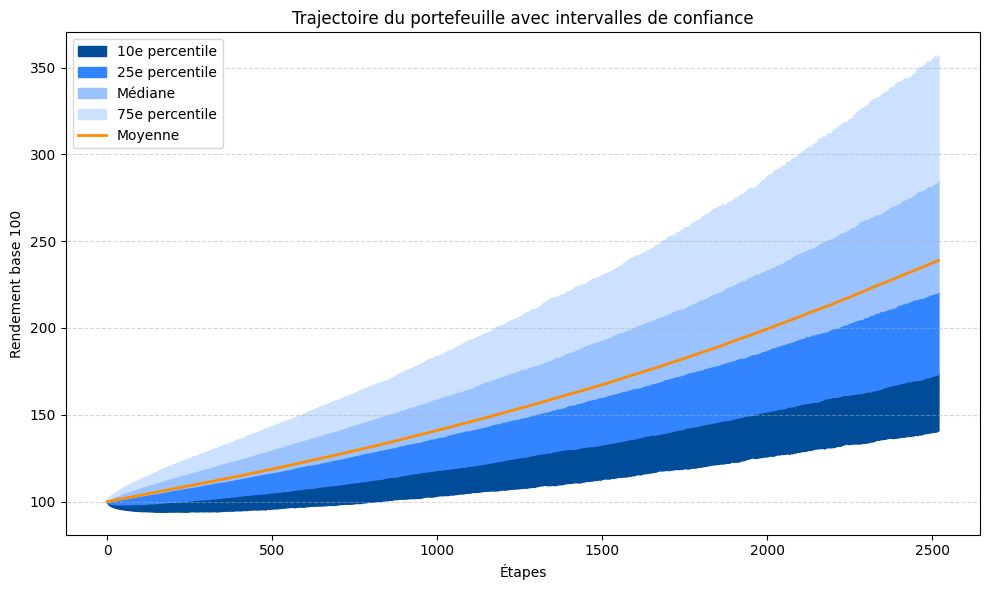

In [34]:
import matplotlib.pyplot as plt

# Calcul des percentiles
p10 = np.percentile(data, 10, axis=1)
p25 = np.percentile(data, 25, axis=1)
p50 = np.percentile(data, 50, axis=1)
p75 = np.percentile(data, 75, axis=1)
p90 = np.percentile(data, 90, axis=1)
mean = np.mean(data, axis=1)

# Tracer les intervalles
plt.figure(figsize=(10, 6))
plt.fill_between(range(n_steps), p10, p25, color="#004c99", alpha=1, label="10e percentile")
plt.fill_between(range(n_steps), p25, p50, color="#3385ff", alpha=1, label="25e percentile")
plt.fill_between(range(n_steps), p50, p75, color="#99c2ff", alpha=1, label="Médiane")
plt.fill_between(range(n_steps), p75, p90, color="#cce0ff", alpha=1, label="75e percentile")
plt.plot(range(n_steps), mean, color="darkorange", linewidth=2, label="Moyenne")
plt.legend()
plt.title("Trajectoire du portefeuille avec intervalles de confiance")
plt.xlabel("Étapes")
plt.ylabel("Rendement base 100")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()